# This notebook requires the development version of require the development version of statsmodels:

#### If you wish to install the development version of statsmodel, it can be installed with the below command:

`pip install git+https://github.com/statsmodels/statsmodels.git`



In [1]:
from __future__ import absolute_import, division, print_function

from datetime import date
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pylab as plt
import seaborn as sns
% matplotlib inline

# Hide warnings during grid searching
import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
# Plot differencing
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    diff2 = diff.diff()
    axs[0].plot(series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    axs[2].plot(diff2)
    axs[2].set_title("Series of Second Differences: {}".format(title))
    return diff, diff2

# Load data

In [3]:
df = pd.read_csv('../data/SLU_total_responses_by_month.csv', header=0, index_col=1, parse_dates=[1])
df.index = pd.to_datetime(df.index)
ts = df.freq[1:-1]

In [5]:
# Examine the basic structure of the data
print('Data shape:', ts.shape, '\n')
print('First 5 observations of the data series:', '\n', ts.head())
print('\n')
print('Last 5 observations of the data series:', '\n', ts.tail())

Data shape: (78,) 

First 5 observations of the data series: 
 date
2010-07-01    109
2010-08-01     87
2010-09-01    105
2010-10-01    130
2010-11-01     81
Name: freq, dtype: int64


Last 5 observations of the data series: 
 date
2016-08-01    234
2016-09-01    181
2016-10-01    210
2016-11-01    196
2016-12-01    187
Name: freq, dtype: int64


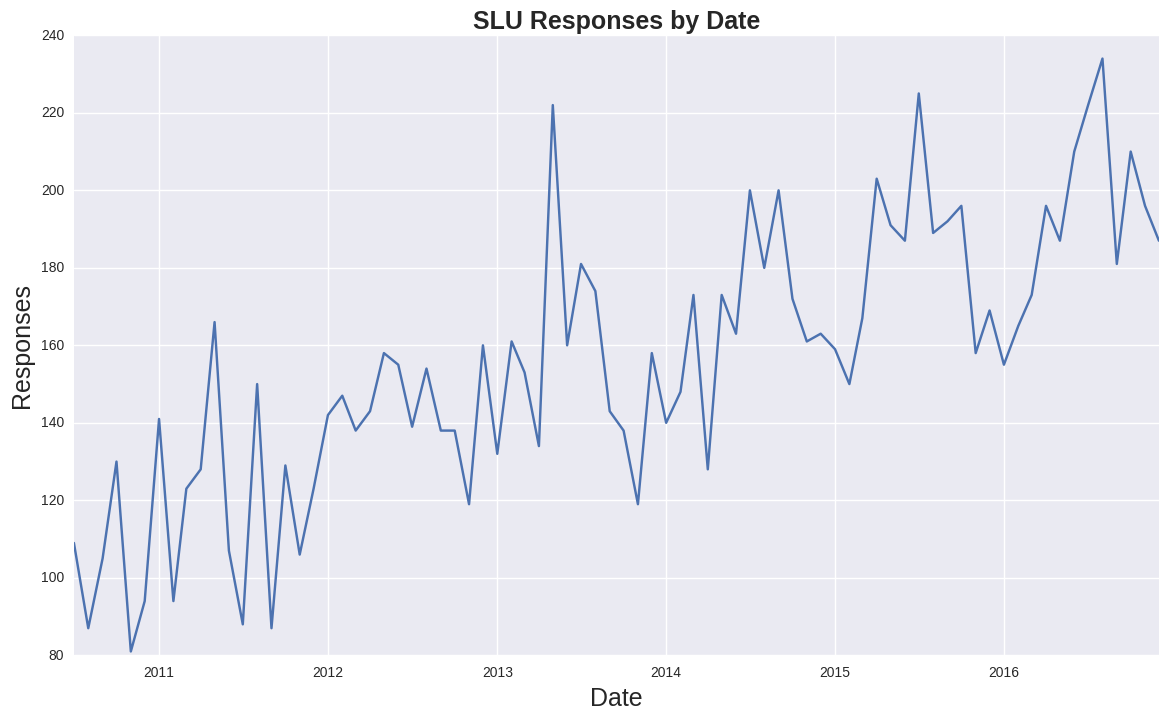

In [5]:
plt.figure(figsize=(14,8))
plt.plot(ts)
plt.title('SLU Responses by Date', fontsize=18, fontweight='bold')
plt.ylabel('Responses', fontsize=18)
plt.xlabel('Date', fontsize=18);

# Tune SARIMAX model

#### It is often best to use the differencing with lowest standard deviation. For this reason d=1 was selected for this model.

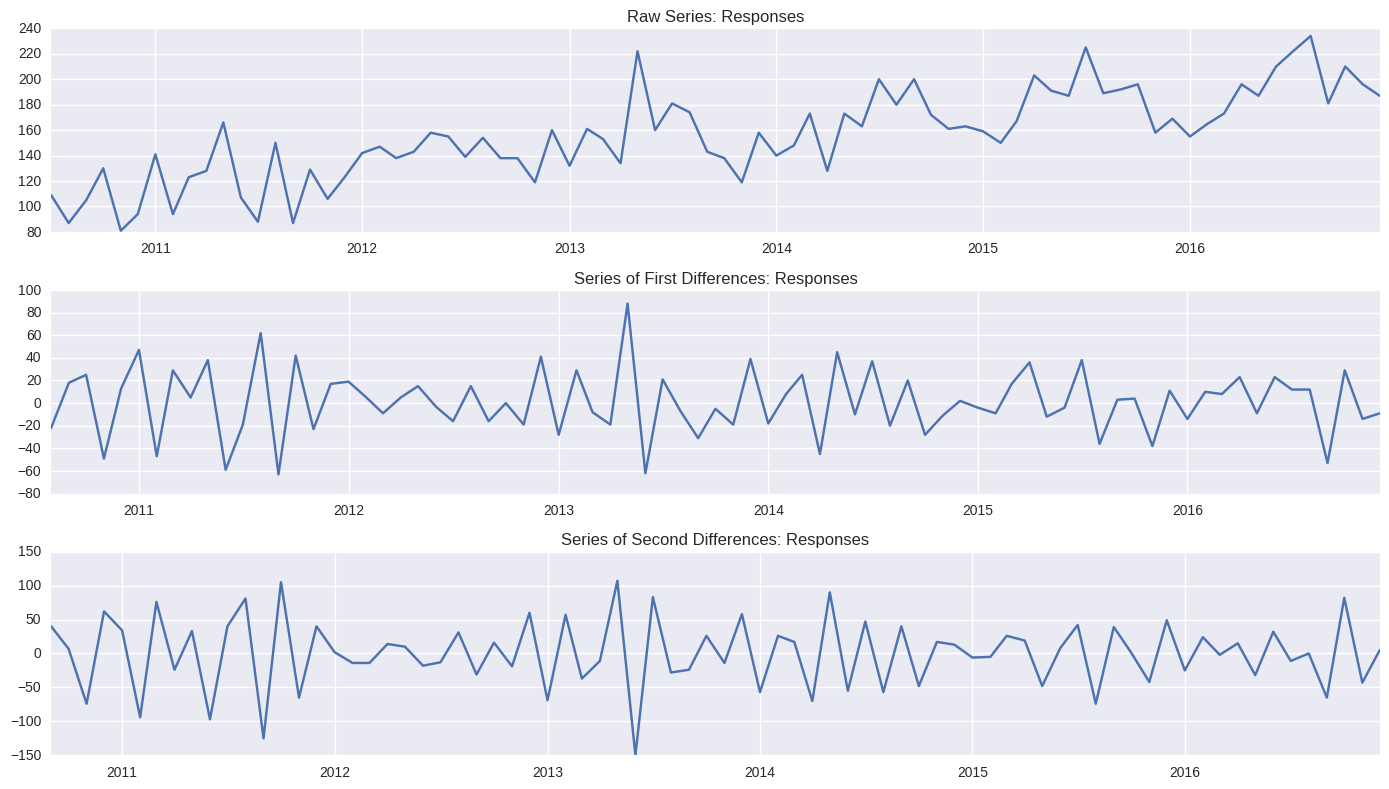

In [7]:
# Plot differencing
fig, axs = plt.subplots(3, figsize=(14, 8))
diff, diff2 = plot_series_and_difference(axs, ts, 'Responses')
fig.tight_layout()

In [8]:
print ('std dev shop_shift:       ', ts.std())
print ('std dev diff1 shop_shift: ', diff.std())
print ('std dev diff2 shop_shift: ', diff2.std())

std dev shop_shift:        35.2463406442
std dev diff1 shop_shift:  29.3609539796
std dev diff2 shop_shift:  52.2272950752


#### Find optimal p and q values with grid searching

In [30]:
parameters = [
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 1},
    {'AR': 0, 'MA': 2},
    {'AR': 1, 'MA': 2},
    {'AR': 2, 'MA': 2},
]

models = {}
for params in parameters:
    model = sm.tsa.statespace.SARIMAX(ts, order=(params['AR'], 1, params['MA']), seasonal_order=(0,1,0,12)).fit()
    print("SARIMAX({}, 1, {}) AIC: {}".format(params['AR'], params['MA'], model.aic))

SARIMAX(1, 1, 0) AIC: 618.356317157
SARIMAX(2, 1, 0) AIC: 606.978641621
SARIMAX(0, 1, 1) AIC: 601.141583887
SARIMAX(1, 1, 1) AIC: 602.116804123
SARIMAX(2, 1, 1) AIC: 602.858575997
SARIMAX(0, 1, 2) AIC: nan
SARIMAX(1, 1, 2) AIC: 603.848314739
SARIMAX(2, 1, 2) AIC: 606.107553231


#### Find optimal seasonal P and Q values with grid searching. The seasonal trend is strong so D=1 was selected (d+D should be less than or equal to 2). It is not recommended to have both P and Q greater than 0. 

In [16]:
# Find P and Q (seasonal p and q) using optimized p and p
parameters = [
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    #{'AR': 0, 'MA': 2}, 
]

models = {}
for params in parameters:
    model = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(params['AR'], 1, params['MA'], 12)).fit()
    print("SARIMAX seasonal({}, 1, {}) AIC: {}".format(params['AR'], params['MA'], model.aic))

SARIMAX seasonal(1, 1, 0) AIC: 596.047943347
SARIMAX seasonal(2, 1, 0) AIC: 597.811489591
SARIMAX seasonal(0, 1, 1) AIC: 595.091181998


# Forecast with SARIMAX model

In [17]:
# Use optimal parameters of (0,1,1)x(0,1,1)12
mod = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(0,1,1,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               freq   No. Observations:                   78
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -294.546
Date:                            Wed, 08 Mar 2017   AIC                            595.091
Time:                                    14:29:38   BIC                            602.161
Sample:                                07-01-2010   HQIC                           597.921
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9984      1.620     -0.616      0.538      -4.174       2.177
ma.S.L12      -0.4314      0.150   

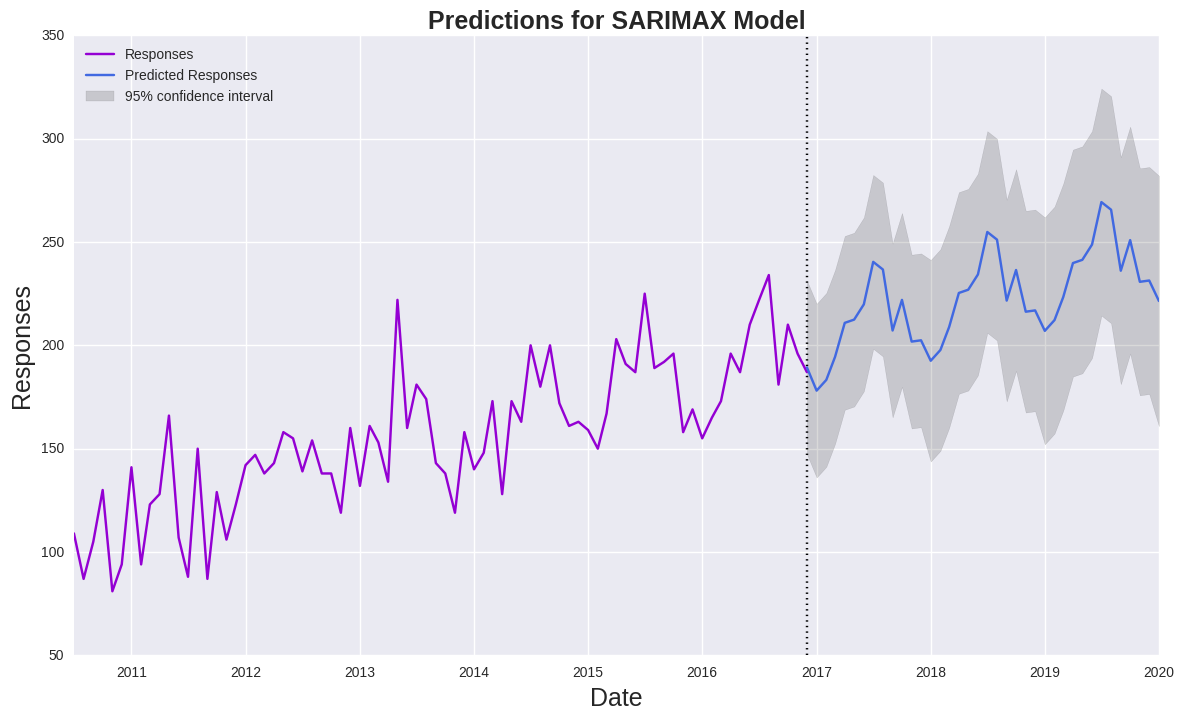

In [24]:
plt.figure(figsize=(14, 8))
plt.title("Predictions for SARIMAX Model", fontsize=18, fontweight='bold')
plt.axvline(date(2016,12,1), color='k', linestyle=':')
# plt.axvline(date(2021,6,1), color='k', linestyle=':')

plt.plot(ts, color='darkviolet', label='Responses')
# plt.plot(ts_test, label='billboard and TV shoppers', color='limegreen')

pred_begin = date(2016,12,1)
pred_end = date(2020,1,1)
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                  end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci95 = pred.conf_int(alpha=0.05)
pred_ci75 = pred.conf_int(alpha=0.25)

plt.plot(pred_mean, 'royalblue', label='Predicted Responses')
plt.fill_between(pred_ci95.index,
                 pred_ci95.iloc[:, 0],
                 pred_ci95.iloc[:, 1], color='k', alpha=0.15, label='95% confidence interval')
# plt.fill_between(pred_ci75.index,
#                  pred_ci75.iloc[:, 0],
#                  pred_ci75.iloc[:, 1], color='k', alpha=0.2, label='75% confidence interval')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Responses", fontsize=18)
plt.title
#plt.ylim(0,450000)
plt.legend(loc=2)
plt.savefig('../images/time_series.png');